<a href="https://colab.research.google.com/github/Lrraymond13/collab/blob/master/LRR_2_MIT_6_036_HW10_Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MIT 6.036 Spring 2019: Homework 10#

This colab notebook provides code and a framework for questions 2, 3, and 4 from [homework 10](https://lms.mitx.mit.edu/courses/course-v1:MITx+6.036+2019_Spring/courseware/Week10/week10_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.

In [1]:
!rm -rf code_for_hw10* __MACOSX data .DS_Store
!wget --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw10/code_for_hw10.zip
!unzip code_for_hw10.zip
!mv code_for_hw10/* .

import code_for_hw10 as code_for_hw10
import mdp10 as mdp

import numpy as np
import math as m
import random

import pdb
from dist import uniform_dist, delta_dist, mixture_dist, DDist
from util import argmax_with_val, argmax
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam

import importlib

Archive:  code_for_hw10.zip
   creating: code_for_hw10/
  inflating: code_for_hw10/util.py   
  inflating: code_for_hw10/mdp10.py  
   creating: __MACOSX/
   creating: __MACOSX/code_for_hw10/
  inflating: __MACOSX/code_for_hw10/._mdp10.py  
  inflating: code_for_hw10/code_for_hw10.py  
  inflating: code_for_hw10/dist.py   


Using TensorFlow backend.


,,,,,,,,,


# 2) Implement Q-Learning

We'll work up to implementing the Q-learning algorithm by extending our code from HW9. In the next block, please copy and paste your implementations of the following functions from HW9.

In [0]:
def value_iteration(mdp, q, eps = 0.01, max_iters = 1000):
    def v(s):
        return value(q,s)
    for it in range(max_iters):
        new_q = q.copy()
        delta = 0
        for s in mdp.states:
            for a in mdp.actions:
                new_q.set(s, a, mdp.reward_fn(s, a) + mdp.discount_factor * \
                          mdp.transition_model(s, a).expectation(v))
                delta = max(delta, abs(new_q.get(s, a) - q.get(s, a)))
        if delta < eps:
            return new_q
        q = new_q
    return q

def value(q, s):
    # Your code here (COPY FROM HW9)
    return max(q.get(s, a) for a in q.actions)

def greedy(q, s):
    """ Return pi*(s) based on a greedy strategy.

    >>> q = TabularQ([0,1,2,3],['b','c'])
    >>> q.set(0, 'b', 5)
    >>> q.set(0, 'c', 10)
    >>> q.set(1, 'b', 2)
    >>> greedy(q, 0)
    'c'
    >>> greedy(q, 1)
    'b'
    """
    # solution is: return argmax(q.actions, lambda a: q.get(s, a))
    # Your code here
    possible_actions = q.actions
    max_v = -float('inf')
    best_a = None
    for a in possible_actions:
      if q.get(s,a) >= max_v:
        max_v = q.get(s,a)
        best_a = a
    return best_a

def epsilon_greedy(q, s, eps = 0.5):
    """ Returns an action.

    >>> q = TabularQ([0,1,2,3],['b','c'])
    >>> q.set(0, 'b', 5)
    >>> q.set(0, 'c', 10)
    >>> q.set(1, 'b', 2)
    >>> eps = 0.
    >>> epsilon_greedy(q, 0, eps) #greedy
    'c'
    >>> epsilon_greedy(q, 1, eps) #greedy
    'b'
    """
    if random.random() < eps:  # True with prob eps, random action
        return uniform_dist(q.actions).draw()
    else:                   # False with prob 1-eps, greedy action
        return greedy(q, s)

Run the next code block to make sure what you need from HW9 is working.

In [4]:
mdp.value = value
mdp.greedy = greedy
mdp.epsilon_greedy = epsilon_greedy
mdp.value_iteration = value_iteration

importlib.reload(code_for_hw10)

# Test: Value Iteration
code_for_hw10.test_solve_play()

# Expected output:
# '''
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# Reward 100
# '''

,,,,,,,,,


Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100


## 2.1) Q update

First, we'll extend our implementation of the TabularQ class in HW 9 (Problem 5) to incorporate the crucial operation of Q-learning, which is to update the Q value for a given `(s, a)` entry and move it part of the way towards a "target" value *t*.

> *Q(s,a) ← (1−α)Q(s,a) + αt*

Note that this can also be written as:

> *Q(s,a)← Q(s,a)+α(t−Q(s,a))*

That is, move a small (*α*) step towards t.

Let's define a new method for `TabularQ` that implements this, in a batched form. We will be given a list of `(s, a, t)` triples and have to do all the updates. Note that update is a method of the `TabularQ` class, so you can access the other methods and attributes.

* `data` is a list of `(s, a, t)` tuples.
* `lr` is a learning rate (*α* above)
* We will have to update `self.q[(s,a)]` for all of the data.


In [0]:
class TabularQ:
    def __init__(self, states, actions):
        self.actions = actions
        self.states = states
        self.q = dict([((s, a), 0.0) for s in states for a in actions])
    def copy(self):
        q_copy = TabularQ(self.states, self.actions)
        q_copy.q.update(self.q)
        return q_copy
    def set(self, s, a, v):
        self.q[(s,a)] = v
    def get(self, s, a):
        return self.q[(s,a)]
    def update(self, data, lr):
      for (s, a, t) in data:
        self.q[(s, a)] = (1 - lr) * self.q[(s, a)] + lr * t

## 2.2) Q_learn

Complete the definition of the `Q_learn` function. It should update the entries in the `q` function, `(s, a)`, towards their estimated Q values. It should terminate after `iters` iterations and use learning rate `lr`. Use the `q.update` method, which you just wrote, to update the Q values.

You will need to both simulate the agent's trajectory through the space as well as perform the updates to the Q function estimates. In this version, you should update the Q values after every transition, using a single `(s, a, t)` tuple. **The following methods and functions have already been defined for you.**


* To start a new simulation, call `mdp.init_state()`. That will draw a state from the MDP's initial state distribution.
* You can use the functions that we defined in HW 9: `epsilon_greedy` for action selection (epsilon_greedy takes `(q, s, eps = 0.5)` as input and returns an action) `value` takes `(q, s)` and returns the max Q value for a state.
* To take a step in the simulation, starting in a given state, `s`, using action a, call `mdp.sim_transition(s,a)`. It will return a pair `(r, s_prime)` denoting the reward received by the agent at that step and the next state.
* Be careful in treating terminal states. Recall that at a terminal state, there may be an immediate reward but the future expected value will be zero.
* Return `q` so that the Tutor can test it.

In [0]:
def Q_learn(mdp, q, lr=.1, iters=100, eps=0.5, interactive_fn=None):
    s = mdp.init_state()
    for i in range(iters):
        a = epsilon_greedy(q, s, eps)
        r, s_prime = mdp.sim_transition(s, a)
        future_val = 0 if mdp.terminal(s) else value(q, s_prime)
        q.update([(s, a, (r + mdp.discount_factor * future_val))], lr)
        s = s_prime
        if interactive_fn: interactive_fn(q, i)
    return q

In [21]:
mdp.TabularQ = TabularQ
mdp.Q_learn = Q_learn
importlib.reload(code_for_hw10)

,,,,,,,,,


<module 'code_for_hw10' from '/content/code_for_hw10.py'>

Run the next code block to test your implementation of `Q_learn`.

In [9]:
def tinyTerminal(s):
    return s==4
def tinyR(s, a):
    if s == 1: return 1
    elif s == 3: return 2
    else: return 0
def tinyTrans(s, a):
    if s == 0:
        if a == 'a':
            return DDist({1 : 0.9, 2 : 0.1})
        else:
            return DDist({1 : 0.1, 2 : 0.9})
    elif s == 1:
        return DDist({1 : 0.1, 0 : 0.9})
    elif s == 2:
        return DDist({2 : 0.1, 3 : 0.9})
    elif s == 3:
        return DDist({3 : 0.1, 0 : 0.5, 4 : 0.4})
    elif s == 4:
        return DDist({4 : 1.0})
      
def testQ():
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = TabularQ(tiny.states, tiny.actions)
    qf = Q_learn(tiny, q)
    ret = list(qf.q.items())
    expected = [((0, 'a'), 0.6649739221724159), ((0, 'b'), 0.1712369526453748), 
                ((1, 'a'), 0.7732751316011999), ((1, 'b'), 1.2034912054227331), 
                ((2, 'a'), 0.37197205380133874), ((2, 'b'), 0.45929063274463033), 
                ((3, 'a'), 1.5156163024818292), ((3, 'b'), 0.8776852768653631), 
                ((4, 'a'), 0.0), ((4, 'b'), 0.0)]
    ok = True
    for (s,a), v in expected:
      qv = qf.get(s,a)
      if abs(qv-v) > 1.0e-5:
        print("Oops!  For (s=%s, a=%s) expected %s, but got %s" % (s, a, v, qv))
        ok = False
    if ok:
      print("Tests passed!")

random.seed(0)
testQ()      

Oops!  For (s=0, a=a) expected 0.6649739221724159, but got 0.8048428363707812
Oops!  For (s=0, a=b) expected 0.1712369526453748, but got 0.19316690253968336
Oops!  For (s=1, a=a) expected 0.7732751316011999, but got 0.48495610433794933
Oops!  For (s=1, a=b) expected 1.2034912054227331, but got 1.3805655733690563
Oops!  For (s=2, a=a) expected 0.37197205380133874, but got 0.24844196150564404
Oops!  For (s=2, a=b) expected 0.45929063274463033, but got 0.5958300672555848
Oops!  For (s=3, a=a) expected 1.5156163024818292, but got 0.5613052311726843
Oops!  For (s=3, a=b) expected 0.8776852768653631, but got 1.744480863854994


## 2.3) Batch Q_learn

Assume your previous update method has been defined.

In the standard Q-learning algorithm, we make one epsilon-greedy transition based on the current Q estimate and then update the Q values. You can think of this as being like stochastic gradient descent. We can also define a version that is more like batch gradient descent, where we generate one or more "episodes" (sequences of transitions) using the current Q values and then update the Q values based on all the observed results. We can also keep around old transitions and use them (all or a random subset) in the update as well. **Note that as our Q value estimate evolves, the target Q value computed from a previously observed transition can change.**

Implement this version of batch Q-learning that (a) generates some specifed number of episodes of a given length (see `sim_episode` below), (b) adds these to the experiences we have seen previously, and (c) updates the Q estimates based on **all the experience so far**. Return `q` so that the Tutor can test it.

In [0]:
# evaluate this cell so you can use the definition in your code below

def sim_episode(mdp, episode_length, policy, draw=False):
    '''
    Simulate an episode (sequence of transitions) of at most
    episode_length, using policy function to select actions.  If we find
    a terminal state, end the episode.  Return accumulated reward a list
    of (s, a, r, s') where s' is None for transition from terminal state.
    Also return an animation if draw=True, or None if draw=False
    '''
    episode = []
    reward = 0
    s = mdp.init_state()
    all_states = [s]
    for i in range(episode_length):
        a = policy(s)
        (r, s_prime) = mdp.sim_transition(s, a)
        reward += r
        if mdp.terminal(s):
            episode.append((s, a, r, None))
            break
        episode.append((s, a, r, s_prime))
        if draw: 
            mdp.draw_state(s)
        s = s_prime
        all_states.append(s)
    animation = animate(all_states, mdp.n, episode_length) if draw else None
    return reward, episode, animation

**Clarifications**

* There should be a SINGLE call to `q.update` per iteration, not per episode or per experience. Just one call per iteration, with a lot of data.
* Let's understand the distinction between experiences `(s, a, r, s')` and Q targets `(s, a, t)`. Note that experiences don't depend on the current estimated Q values (only on the environment we are acting in), but the "t" in the Q targets depends on the current Q values. So, it makes sense to store experiences across iterations, but not to store Q targets, since the Q targets change when we update our Q values. Thus, you want to continuously aggregate the experience and then, in each iteration, re-compute the Q targets under the current estimated Q values, then do the update with all of these Q targets. Here's pseudocode:


```
all_experiences = []
Loop over n_iterations:
    Loop over n_episodes:
        Generate an episode of length episode_length, append this experience to all_experiences
    all_q_targets = []
    Loop over all_experiences:
        Append Q target from one experience to all_q_targets
        Remember to handle terminal states (where s' = None)
    q.update(all_q_targets, lr)
return q
```



In [0]:
def Q_learn_batch(mdp, q, lr=.1, iters=100, eps=0.5,
                               episode_length=10, n_episodes=2,
                  interactive_fn=None):
    all_experiences = []
    explore = lambda s: epsilon_greedy(q,s,eps)
    for i in range(iters):
        for e in range(n_episodes):
            _, episode, _ = sim_episode(mdp, episode_length, explore)
            all_experiences += episode
        all_q_targets = []
        for (s, a, r, s_prime) in all_experiences:
            future_val = 0 if s_prime is None else value(q, s_prime)
            all_q_targets.append((s, a, (r + mdp.discount_factor * future_val)))
        q.update(all_q_targets, lr)
        if interactive_fn: interactive_fn(q, i)
    return q

Run the next code block to test your implementation of `Q_learn_batch`.

In [12]:
def testBatchQ():
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = TabularQ(tiny.states, tiny.actions)
    qf = Q_learn_batch(tiny, q)
    ret = list(qf.q.items())
    expected = [((0, 'a'), 4.7566600197286535), ((0, 'b'), 3.993296047838986), 
                ((1, 'a'), 5.292467934685342), ((1, 'b'), 5.364014782870985), 
                ((2, 'a'), 4.139537149779127), ((2, 'b'), 4.155347555640753), 
                ((3, 'a'), 4.076532544818926), ((3, 'b'), 4.551442974149778), 
                ((4, 'a'), 0.0), ((4, 'b'), 0.0)]

    ok = True
    for (s,a), v in expected:
      qv = qf.get(s,a)
      if abs(qv-v) > 1.0e-5:
        print("Oops!  For (s=%s, a=%s) expected %s, but got %s" % (s, a, v, qv))
        ok = False
    if ok:
      print("Tests passed!")
      
      return list(qf.q.items())

random.seed(0)
testBatchQ()

Oops!  For (s=0, a=a) expected 4.7566600197286535, but got 4.719373048773068
Oops!  For (s=0, a=b) expected 3.993296047838986, but got 3.9894502668007856
Oops!  For (s=1, a=a) expected 5.292467934685342, but got 5.229379765859235
Oops!  For (s=1, a=b) expected 5.364014782870985, but got 5.387604894868419
Oops!  For (s=2, a=a) expected 4.139537149779127, but got 4.719721562235436
Oops!  For (s=2, a=b) expected 4.155347555640753, but got 4.75645231638034
Oops!  For (s=3, a=a) expected 4.076532544818926, but got 5.054037583555434
Oops!  For (s=3, a=b) expected 4.551442974149778, but got 4.16591736629545


# 3) NN Q

Now we will combine neural networks with Q-learning. There are a wide variety of ways to do this, some of which are referred to as "deep Q-learning". They all hinge on the following ideas, which are explained in depth in the notes:

* We would like to operate in large or continuous state and/or action spaces so it is not possible (or effective) to store the *Q* values in a table; instead, we will "store" them by training a neural network to do regression for us, taking *s, a* as input and generating (an approximation of) *Q∗(s,a)* as output.
* To train the network, we will use *squared Bellman error* as the loss function (see [homework 10](https://lms.mitx.mit.edu/courses/course-v1:MITx+6.036+2019_Spring/courseware/Week10/week10_homework/) for equation).

We will explore two different algorithms and one input representation. There are many choices of neural network architecture. We are going to work on a problem with a very small set (size 3) of actions and we will:

* Make one neural network for each possible action *a*.
* Design that network with 2 **hidden** layers, with ReLU units, and a single linear output unit; and
* Use mean squared error (mse) as the loss function since we are doing regression
* Use `Adam()` as your optimizer.

In [0]:
# In Keras, we would create such a network using the following function
# please evaluate this cell so you can use it in your code

def make_nn(state_dim, num_hidden_layers, num_units):
    '''
    state_dim =	(int) number of states
    num_hidden_layers =	(int) number of	fully connected hidden layers
    num_units =	(int) number of	dense relu units to use	in hidden layers
    '''  
    model = Sequential()
    model.add(Dense(num_units, input_dim = state_dim, activation='relu'))
    for i in range(num_hidden_layers-1):
        model.add(Dense(num_units, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam())
    return model

## 3.1) Basic neural network Q-learning

We'll call the first algorithm *basic neural network Q-learning*. It was the first strategy to be used to combine Q-learning and neural networks, and suffers from the *correlated experience* problem described in the notes. However, it is relatively easy to implement and works okay on very simple problems.

In basic NN Q-learning, just as in the version of Q-learning we implemented above, you simulate a trajectory through state space, using *ϵ*-greedy action selection, and making an update to your Q functions after each piece of experience *(s, a, r, s′)*. You do this by doing one epoch of training on your network for action *a*, on a data set made up of a single data point, where the input is *s* and the desired output is *r + γ max_a' Q(s', a')*, using the current estimates of *Q*.

This might sound very familiar. In fact, it is exactly `Q_learn` except that instead of using a tabular representation of the the Q function, we are using a neural net to approximate the Q values for the state. In particular, the update method corresponds to training the neural net with the target Q value.

To use a neural net implementation of Q values, for a given action, we will need to have a mapping from states to fixed-length row vectors. We will assume that the `MDP` class has a `state2vec` method that maps states to vectors. For the simple MDPs we have seen so far, this simply returns a one-hot representation of the state.

Now, all we need is to write a new class to implement the Q function and then we should be able to use the `Q_learn` directly to do Neural Net Q-learning (NNQ). **The arguments to the `get` and `update` methods are the same as those in `TabularQ`; please review those now.**

We will assume that we have a small number of actions and we will use a neural net to learn the Q values for each action. Keep a dictionary of these NN models in `self.models` using the action as the key. Note that you have access to `make_nn` which was previously described.

For each `update` call, create one training set for each action *a*:

1. Extract the tuples from your data set that contain action aa. Recall that the `data` tuples are of the form `(s, a, t)`, where t is a target Q value.
2. Let the *X* values of your training set be all of the *s* values from your data tuples with action *a* and the *Y* values be the target Q values given in the data tuples.

Train the network for action *a* for the specified number of epochs, using `self.models[a].fit(X, Y, epochs=epochs)`. In Basic Q-Learning, we will always use `epochs=1`, but make this a general argument in creating an instance of the class. **Ignore the `lr` argument to the `update` method, we'll let Adam pick learning rates.**

In [0]:
class NNQ:
    def __init__(self, states, actions, state2vec, num_layers, num_units, epochs=1):
        self.actions = actions
        self.states = states
        self.epochs = epochs
        self.state2vec = state2vec
        state_dim = state2vec(states[0]).shape[1] # a row vector
        self.models = {a:make_nn(state_dim, num_layers, num_units) for a in actions}
    def get(self, s, a):
        return self.models[a].predict(self.state2vec(s))
    def update(self, data, lr):
        for a in self.actions:
            if [s for (s, at, t) in data if a==at]:
                X = np.vstack([self.state2vec(s) for (s, at, t) in data if a==at])
                Y = np.vstack([t for (s, at, t) in data if a==at])
                self.models[a].fit(X, Y, epochs = self.epochs, verbose = False)

In [22]:
make_nn = mdp.make_nn
mdp.NNQ = NNQ
importlib.reload(code_for_hw10)

,,,,,,,,,


<module 'code_for_hw10' from '/content/code_for_hw10.py'>

Run the next code block to test your implementation of `NNQ`.

In [23]:
def test_NNQ(data):
    tiny = mdp.MDP([0, 1, 2, 3, 4], ['a', 'b'], tinyTrans, tinyR, 0.9)
    tiny.terminal = tinyTerminal
    q = NNQ(tiny.states, tiny.actions, tiny.state2vec, 2, 10)
    q.update(data, 1)
    ret =  [q.get(s,a) for s in q.states for a in q.actions]
    expect = [np.array([[-0.07211456]]), np.array([[-0.19553234]]), 
              np.array([[-0.21926211]]), np.array([[0.01699455]]), 
              np.array([[-0.26390356]]), np.array([[0.06374809]]), 
              np.array([[0.0340214]]), np.array([[-0.18334733]]), 
              np.array([[-0.438375]]), np.array([[-0.13844737]])]
    cnt = 0
    ok = True
    for s in q.states:
      for a in q.actions:
        if not np.all(np.abs(ret[cnt]-expect[cnt]) < 1.0e0):
          print("Oops, for s=%s, a=%s expected %s but got %s" % (s, a, expect[cnt], ret[cnt]))
          ok = False
        cnt += 1
    if ok:
      print("Output looks generally ok")
    return q
  
test_NNQ([(0,'a',0.3),(1,'a',0.1),(0,'a',0.1),(1,'a',0.5)])

Output looks generally ok


## 3.2) Fitted Q iteration

*Fitted Q iteration (FQ)* suffers less from the correlated experience problem and is generally more stable (and sometimes slower) than NNQ.

FQ initializes the Q networks and an empty data set, then operates in a loop:

1. Use *ϵ*-greedy exploration to generate *k* steps of experience, of the form *(s,a,r,s′)* and add them to the data set.
2. Create one training set for each action *a*:

> 1. Extract all the tuples from your data set that contain action *a*,
> 2. Let the *X* values of your training set be all of the *s* values from your data tuples with action *a* and the *Y* values be the *r + γ max_a' Q(s', a')* values computed for each data tuple, using the Q estimates from the current network.

3. Train the network for action *a* for several epochs until it has done a good job of representing this data.

So, this is basically `Q_learn_batch` using `NNQ` (training with multiple epochs) to implement the Q function.

Run the next code block to test your implementation of `NNQ` with batching.

score (0, 9.9)
score (10000, 12.4)
score (20000, 100.0)
score (30000, 66.3)
score (40000, 100.0)
score (50000, 100.0)
score (60000, 75.1)
score (70000, 100.0)
score (80000, 100.0)
score (90000, 91.7)
String to upload (incude quotes): "286c70300a4930300a614930300a61286c70310a284c304c0a46392e390a7470320a61284c31303030304c0a4631322e340a7470330a61284c32303030304c0a463130302e300a7470340a61284c33303030304c0a4636362e330a7470350a61284c34303030304c0a463130302e300a7470360a61284c35303030304c0a463130302e300a7470370a61284c36303030304c0a4637352e310a7470380a61284c37303030304c0a463130302e300a7470390a61284c38303030304c0a463130302e300a747031300a61284c39303030304c0a4639312e370a747031310a61612e"


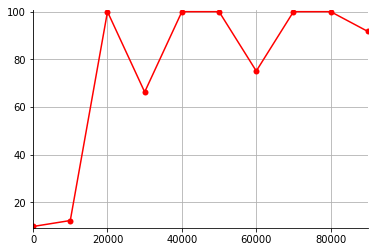

Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 100
Reward 30
Reward 100


In [28]:
# Test: NN Batch Q-learn (Fitted Q-learn)
code_for_hw10.test_learn_play(iters=100000, tabular=False, batch=False)

#4) No Exit

Please read the instructions in the [homework](https://lms.mitx.mit.edu/courses/course-v1:MITx+6.036+2019_Spring/courseware/Week10/week10_homework/) to set up for the game. You may use this space to display the game in Colab.

In [0]:
code_for_hw10.test_solve_play(draw = True)